
0: 480x640 10 objects, 272.8ms
Speed: 19.3ms preprocess, 272.8ms inference, 128.2ms postprocess per image at shape (1, 3, 480, 640)
Skipping segment 0 due to size constraints


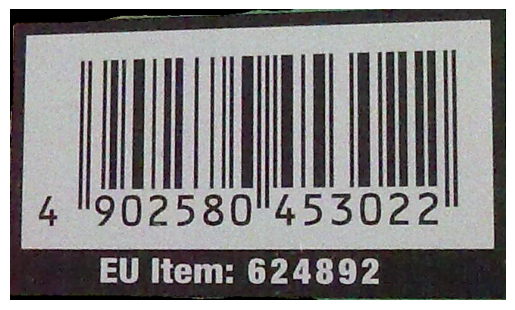

Skipping segment 2 due to size constraints
Skipping segment 3 due to segmenation problem
Skipping segment 4 due to size constraints
Skipping segment 5 due to size constraints
Skipping segment 6 due to size constraints


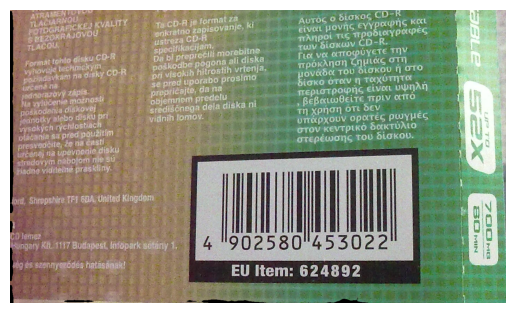

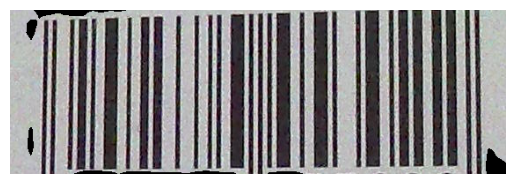

Skipping segment 9 due to size constraints


In [49]:
import os
import cv2
import numpy as np
from PIL import Image
import torch
from ultralytics import FastSAM
from scipy import stats
import matplotlib.pyplot as plt


def check(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ddepth = cv2.CV_32F 
    gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
    gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)
    blurred = cv2.blur(gradient, (9, 9))
    _, thresh = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    closed = cv2.erode(closed, None, iterations=4)
    closed = cv2.dilate(closed, None, iterations=4)
    cnts, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return 0
    c = max(cnts, key=cv2.contourArea)
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int32(box) 
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    return 1


def extract_segments(image_path):
    output_dir = "./segments"
    os.makedirs(output_dir, exist_ok=True)
    model = FastSAM('FastSAM-s.pt')
    original_image = Image.open(image_path)
    image_np = np.array(original_image)
    image_area = original_image.size[0] * original_image.size[1]
    results = model(original_image, device='cuda' if torch.cuda.is_available() else 'cpu',
                    retina_masks=True, conf=0.4, iou=0.9)
    annotations = results[0].masks.data
    if annotations is None:
        print("No segments detected")
        return []
    segments = []
    for idx, annotation in enumerate(annotations):
        mask = annotation.cpu().numpy()
        mask = cv2.resize(mask, (original_image.size[0], original_image.size[1]))
        mask = mask > 0.5
        segment = np.zeros_like(image_np)
        
        segment[mask] = image_np[mask]
        
        y_indices, x_indices = np.where(mask)
        if len(y_indices) > 0 and len(x_indices) > 0:
            x_min, x_max = np.min(x_indices), np.max(x_indices)
            y_min, y_max = np.min(y_indices), np.max(y_indices)
            bbox_area = (x_max - x_min + 1) * (y_max - y_min + 1)
            if bbox_area < 0.05 * image_area or bbox_area > 0.9 * image_area:
                print(f"Skipping segment {idx} due to size constraints")
                continue
    
            cropped_segment = segment[y_min:y_max+1, x_min:x_max+1]
            if(check(cropped_segment)==0):
                print(f"Skipping segment {idx} due to segmenation problem")
                continue
            cv2.imwrite(f"{output_dir}/segment_{idx}.png", cv2.cvtColor(cropped_segment, cv2.COLOR_RGB2BGR))
            segments.append({'index': idx, 'mask': mask, 'cropped_segment': cropped_segment})
    
    return segments

def main():
    image_path = "/Users/sanchitjalan/Desktop/5th_sem/DIP/DIP_Project/BarcodeDatasets/Dataset1/05102009108.jpg"
    
    try:
        segments = extract_segments(image_path)

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

In [53]:
import zxing

image_path = "/Users/sanchitjalan/Desktop/5th_sem/DIP/DIP_Project/segments/segment_8.png"  
reader = zxing.BarCodeReader()
barcode = reader.decode(image_path)
if barcode:
    print("Type:", barcode.format)
    print("Data:", barcode.raw)
else:
    print("No barcode detected.")


Type: EAN_13
Data: 4902580453022
